In [13]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os,sys
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler


import re, pickle
from torch.utils.data import DataLoader, random_split


In [14]:
# Reproducibility
common.set_seed(1)

In [15]:
layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}
lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1  
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
outputs = 10
inputs = 1

In [16]:
trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform_mnist)
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

In [17]:
class BBBLeNet(common.ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBLeNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if layer_type=='lrt':
            BBBLinear = common.layers.BBB_LRT_Linear
            BBBConv2d = common.layers.BBB_LRT_Conv2d
        elif layer_type=='bbb':
            BBBLinear = common.layers.BBB_Linear
            BBBConv2d = common.layers.BBB_Conv2d
        else:
            raise ValueError("Undefined layer_type")
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = common.layers.FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinear(5 * 5 * 16, 120, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.fc2 = BBBLinear(120, 84, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.fc3 = BBBLinear(84, outputs, bias=True, priors=self.priors)

In [18]:
class LeNet(nn.Module):

    def __init__(self, outputs, inputs, layer_type='lrt', activation_type='softplus'):
        '''
        Base LeNet model that matches the architecture of BayesianLeNet with randomly 
        initialized weights
        '''
        super(LeNet, self).__init__()
        
        # initialization follows the BBBLeNet initialization, changing
        # BBBLinear and BBBConv2D layers to nn.Linear and nn.Conv2D
        
        if activation_type == 'softplus':
            self.act = nn.Softplus
        elif activation_type == 'relu':
            self.act = nn.ReLU

        self.conv1 = nn.Conv2d(inputs, 6, 5, padding=0, bias=True)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0, bias=True)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120, bias=True)
        self.act3 = self.act()
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.act4 = self.act()
        self.fc3 = nn.Linear(84, outputs, bias=True)


    def sample(self, bbbnet):
        '''
        Takes in a BBBLeNet instance and copies the structure into a LeNet model.
        Replaces the BBBLinear and BBBConv2D that uses sampling in their forward steps
        with regular nn.Linear and nn.Conv2d layers whose weights are initialized by 
        sampling the BBBLeNet model.
        '''    
        ### store activation function used by BNN, only relu and softplus  currently supported
        self.act1 = bbbnet.act()
        self.act2 = bbbnet.act()
        self.act3 = bbbnet.act()
        self.act4 = bbbnet.act()

        ### maxpool
        self.pool1 = nn.MaxPool2d(kernel_size=bbbnet.pool1.kernel_size, stride=bbbnet.pool1.stride)
        self.pool2 = nn.MaxPool2d(kernel_size=bbbnet.pool2.kernel_size, stride=bbbnet.pool2.stride)
        
        ### Create Convolution layers
        self.conv1 = nn.Conv2d(bbbnet.conv1.in_channels, bbbnet.conv1.out_channels, bbbnet.conv1.kernel_size,
                                stride=bbbnet.conv1.stride, padding=bbbnet.conv1.padding, dilation=bbbnet.conv1.dilation,
                                groups=bbbnet.conv1.groups)
        
        self.conv2 = nn.Conv2d(bbbnet.conv2.in_channels, bbbnet.conv2.out_channels, bbbnet.conv2.kernel_size,
                        stride=bbbnet.conv2.stride, padding=bbbnet.conv2.padding, dilation=bbbnet.conv2.dilation,
                        groups=bbbnet.conv2.groups)
        
        # follows the procedure for sampling in the forward methods of BBBConv and 
        # BBBLinearforward to create a fixed set of weights to use for the sampled model

        conv1_W_mu = bbbnet.conv1.W_mu
        conv1_W_rho = bbbnet.conv1.W_rho
        conv1_W_eps = torch.empty(conv1_W_mu.size()).normal_(0,1)
        conv1_W_sigma = torch.log1p(torch.exp(conv1_W_rho))
        conv1_weight = conv1_W_mu + conv1_W_eps * conv1_W_sigma
        if bbbnet.conv1.use_bias:
            conv1_bias_mu = bbbnet.conv1.bias_mu
            conv1_bias_rho = bbbnet.conv1.bias_rho
            conv1_bias_eps = torch.empty(conv1_bias_mu.size()).normal_(0,1)
            conv1_bias_sigma = torch.log1p(torch.exp(conv1_bias_rho))
            conv1_bias = conv1_bias_mu + conv1_bias_eps * conv1_bias_sigma
        else:
            conv1_bias = None
        self.conv1.weight.data = conv1_weight.data
        self.conv1.bias.data = conv1_bias.data


        conv2_W_mu = bbbnet.conv2.W_mu
        conv2_W_rho = bbbnet.conv2.W_rho
        conv2_W_eps = torch.empty(conv2_W_mu.size()).normal_(0,1)
        conv2_W_sigma = torch.log1p(torch.exp(conv2_W_rho))
        conv2_weight = conv2_W_mu + conv2_W_eps * conv2_W_sigma
        if bbbnet.conv2.use_bias:
            conv2_bias_mu = bbbnet.conv2.bias_mu
            conv2_bias_rho = bbbnet.conv2.bias_rho
            conv2_bias_eps = torch.empty(conv2_bias_mu.size()).normal_(0,1)
            conv2_bias_sigma = torch.log1p(torch.exp(conv2_bias_rho))
            conv2_bias = conv2_bias_mu + conv2_bias_eps * conv2_bias_sigma
        else:
            conv2_bias = None
        self.conv2.weight.data = conv2_weight.data
        self.conv2.bias.data = conv2_bias.data
        
        ### Create Linear Layers
        self.fc1 = nn.Linear(bbbnet.fc1.in_features, bbbnet.fc1.out_features, bbbnet.fc1.use_bias)
        self.fc2 = nn.Linear(bbbnet.fc2.in_features, bbbnet.fc2.out_features, bbbnet.fc2.use_bias)
        self.fc3 = nn.Linear(bbbnet.fc3.in_features, bbbnet.fc3.out_features, bbbnet.fc3.use_bias)

        fc1_W_mu = bbbnet.fc1.W_mu
        fc1_W_rho = bbbnet.fc1.W_rho
        fc1_W_eps = torch.empty(fc1_W_mu.size()).normal_(0,1)
        fc1_W_sigma = torch.log1p(torch.exp(fc1_W_rho))
        fc1_weight = fc1_W_mu + fc1_W_eps * fc1_W_sigma
        if bbbnet.fc1.use_bias:
            fc1_bias_mu = bbbnet.fc1.bias_mu
            fc1_bias_rho = bbbnet.fc1.bias_rho
            fc1_bias_eps = torch.empty(fc1_bias_mu.size()).normal_(0,1)
            fc1_bias_sigma = torch.log1p(torch.exp(fc1_bias_rho))
            fc1_bias = fc1_bias_mu + fc1_bias_eps * fc1_bias_sigma
        else:
            fc1_bias = None
        self.fc1.weight.data = fc1_weight.data
        self.fc1.bias.data = fc1_bias.data

        fc2_W_mu = bbbnet.fc2.W_mu
        fc2_W_rho = bbbnet.fc2.W_rho
        fc2_W_eps = torch.empty(fc2_W_mu.size()).normal_(0,1)
        fc2_W_sigma = torch.log1p(torch.exp(fc2_W_rho))
        fc2_weight = fc2_W_mu + fc2_W_eps * fc2_W_sigma
        if bbbnet.fc2.use_bias:
            fc2_bias_mu = bbbnet.fc2.bias_mu
            fc2_bias_rho = bbbnet.fc2.bias_rho
            fc2_bias_eps = torch.empty(fc2_bias_mu.size()).normal_(0,1)
            fc2_bias_sigma = torch.log1p(torch.exp(fc2_bias_rho))
            fc2_bias = fc2_bias_mu + fc2_bias_eps * fc2_bias_sigma
        else:
            fc2_bias = None
        self.fc2.weight.data = fc2_weight.data
        self.fc2.bias.data = fc2_bias.data

        fc3_W_mu = bbbnet.fc3.W_mu
        fc3_W_rho = bbbnet.fc3.W_rho
        fc3_W_eps = torch.empty(fc3_W_mu.size()).normal_(0,1)
        fc3_W_sigma = torch.log1p(torch.exp(fc3_W_rho))
        fc3_weight = fc3_W_mu + fc3_W_eps * fc3_W_sigma
        if bbbnet.fc3.use_bias:
            fc3_bias_mu = bbbnet.fc3.bias_mu
            fc3_bias_rho = bbbnet.fc3.bias_rho
            fc3_bias_eps = torch.empty(fc3_bias_mu.size()).normal_(0,1)
            fc3_bias_sigma = torch.log1p(torch.exp(fc3_bias_rho))
            fc3_bias = fc3_bias_mu + fc3_bias_eps * fc3_bias_sigma
        else:
            fc3_bias = None
        self.fc3.weight.data = fc3_weight.data
        self.fc3.bias.data = fc3_bias.data

        

    def forward(self, x):
        '''
        Forward method follow the order of BayesianLeNet
        '''
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

In [19]:
net = BBBLeNet(outputs, inputs, priors, layer_type, activation_type)

In [13]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=n_epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [16]:
def load_models(K = 100):
    # Load the models
    sampled_models = [LeNet(outputs, inputs, layer_type, activation_type) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load('models/model-cnn.pt')):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

In [ ]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn.pt")

In [49]:
sampled_models = load_models(K = 50)

Loaded 50 sample models


## Train without Adversarial Examples

In [20]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [27]:
# HyperParameters
epochs = 20
modelname = "CNN_v2"

# Train with BinaryCrossEntropy
val_losses = []
model      = LeNet(outputs, inputs, layer_type, activation_type)
optimizer  = Adam(model.parameters(), lr=lr_start)
lr_sched   = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
loss_fcn   = torch.nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        y    = torch.nn.Softmax()(model(images))
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    lr_sched.step()
    total_loss /= len(train_loader.dataset)
    print("Epoch %g: Loss = %g" % (epoch, total_loss))

torch.save(model, "models/%s.pt" % modelname)
print("Saved the model")

TypeError: step() missing 1 required positional argument: 'metrics'

In [154]:
class LeNet_MNIST(nn.Module):
    def __init__(self):
        super(LeNet_MNIST,self).__init__()
        #Here, we are plementing those layers which are having learnable parameters.
        #Start implementation of Layer 1 (C1) which has 6 kernels of size 5x5 with padding 0 and stride 1
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5))
        
        #Start implementation of Layer 3 (C3) which has 16 kernels of size 5x5 with padding 0 and stride 1

        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = (5,5))
        
        #Start implementation of Layer 5 (C5) which is basically flattening the data 
            
        self.L1 = nn.Linear(256, 120)
        
        #Start implementation of Layer 6 (F6) which has 85 Linear Neurons and input of 120
        
        self.L2 = nn.Linear(120,84)
        
        #Start implementation of Layer 7 (F7) which has 10 Linear Neurons and input of 84
        
        self.L3 = nn.Linear(84,10)
        
        #We have used pooling of size 2 and stride 2 in this architecture 
        
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        
        #We have used tanh as an activation function in this architecture so we will use tanh at all layers excluding F7.
        self.act = nn.Tanh()
        
    #Now we will implement forward function to produce entire flow of the architecture.
    
    def forward(self,x):
        x = self.conv1(x)
        #We have used tanh as an activation function in this architecture so we will use tanh at all layers excluding F7.
        x = self.act(x)
        #Now this will be passed from pooling 
        x = self.pool(x)
        #Next stage is convolution
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        #next we will pass from conv3, here we will not pass data from pooling as per Architecture 
        
        
        #Now the data should be flaten and it would be passed from FC layers. 
        x = x.view(x.size()[0], -1)
        x = self.L1(x)
        x = self.act(x)
        x = self.L2(x)
        x = self.act(x)
        x = self.L3(x)
        
        return x

In [169]:
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np

train = datasets.MNIST(root='.',train=True,transform=ToTensor(),download=True)
test  = datasets.MNIST(root='.',train=False,transform=ToTensor(),download=True)


batch_size = 128
train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test,batch_size=batch_size,shuffle=False)

model = LeNet_MNIST()

lr = 0.001
optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')


def accuracy(outputs,labels):
    _,pred = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(pred==labels).item()/len(pred))

def training_step(batch):
            image,label = batch
            out = model(image)
            loss = loss_fn(out,label)
            return loss
    
def test_step(batch):
            image,label = batch
            out = model(image)
            loss = loss_fn(out,label)
            acc = accuracy(out, label)
            return {'test_loss': loss.detach(), 'test_acc': acc}
    
def training_result(outputs):
            batch_loss = [i['test_loss'] for i in outputs]
            epoch_loss = torch.stack(batch_loss).mean()
            batch_acc = [i['test_acc'] for i in outputs]
            epoch_acc = torch.stack(batch_acc).mean()  
            return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
def epoch_result(epoch,result):
            print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
                epoch, result['train_loss'], result['test_loss'], result['test_acc']))

                        
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return 'cpu'
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device);

def evaluation(model,test_loader):
    model.eval()
    output = [test_step(batch) for batch in test_loader] 
    return training_result(output)

def fit(epochs,model,lr,train_loader,test_loader,optim = optimizer):
    history = []
    for epoch in range(epochs):
        train_loss = []
        model.train()
        for batch in train_loader:
            loss = training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluation(model,test_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        epoch_result(epoch,result)
        history.append(result)
    return history
            
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs,model,lr, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 58.0535, test_loss: 20.5085, test_acc: 0.9515
Epoch [1], train_loss: 16.8563, test_loss: 11.4889, test_acc: 0.9725
Epoch [2], train_loss: 10.9548, test_loss: 8.8285, test_acc: 0.9769
Epoch [3], train_loss: 8.2382, test_loss: 8.4571, test_acc: 0.9786
Epoch [4], train_loss: 6.5166, test_loss: 6.9045, test_acc: 0.9822
Epoch [5], train_loss: 5.5779, test_loss: 6.3462, test_acc: 0.9829
Epoch [6], train_loss: 4.7086, test_loss: 5.5551, test_acc: 0.9867
Epoch [7], train_loss: 4.1655, test_loss: 5.3448, test_acc: 0.9861
Epoch [8], train_loss: 3.3988, test_loss: 5.9889, test_acc: 0.9857
Epoch [9], train_loss: 3.1838, test_loss: 5.0938, test_acc: 0.9867


In [171]:
torch.save(model, "models/CNN.pt")

In [174]:
img = next(iter(test_loader))
img[0].shape

torch.Size([128, 1, 28, 28])

In [172]:
evaluation(model, test_loader)

{'test_loss': 5.093798637390137, 'test_acc': 0.9867483973503113}

## Generate Adv Examples

In [131]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=transform_mnist)

# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(156))

In [86]:
# Get a batch and flatten the input
images, targets = next(iter(test_loader))

In [87]:
images.shape

torch.Size([1, 1, 32, 32])

In [88]:
targets

tensor([8])

In [54]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [55]:
def otcm(images, eps, saliency):
    return torch.clamp(images.clone()-eps*saliency, 0, 1)

In [56]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, eps, saliency):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
        # One step Target Class Method (OTCM); saliency is noise
        new_images = otcm(images, eps, saliency)
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/len(sampled_models)

In [19]:
# Collect noises (saliencies)
EPS = 0.18
saliencies = []
how_many_fooled = []
torch.set_printoptions(sci_mode=False)
for k in range(len(sampled_models)):
    # Forward pass
    # Compute loss w.r.t. an incorrect class
    # Note that we just have to ensure this class is different from targets
    images.grad = None
    images.requires_grad = True
    old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), torch.tensor([1])])
    # Compute adversarial example
    new_images = otcm(images, EPS, images.grad.sign())
    # Forward pass on adv. example
    new_class = forward_pass(sampled_models[k], new_images)
    if old_class != new_class:
        # How many models can this adv. example fool?
        how_many_fooled += [how_many_can_it_fool(sampled_models, EPS, images.grad.sign())]
        saliencies += [images.grad.sign().view(32, 32)]

In [57]:
def generate_saliency(EPS,target,images):
    # Collect noises (saliencies)
    # EPS = 0.18
    saliencies = []
    how_many_fooled = []
    torch.set_printoptions(sci_mode=False)
    # target = torch.tensor([1])
    target = torch.tensor([target])
    for k in range(len(sampled_models)):
        # Forward pass
        # Compute loss w.r.t. an incorrect class
        # Note that we just have to ensure this class is different from targets
        # print("\r Processing " + str(k+1) + "/%s" % len(sampled_models), end="")
        images.grad = None
        images.requires_grad = True
        old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), target])
        # Compute adversarial example
        new_images = otcm(images, EPS, images.grad.sign())
        # Forward pass on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        if old_class != new_class:
            # How many models can this adv. example fool?
            how_many_fooled += [how_many_can_it_fool(sampled_models, EPS, images.grad.sign())]
            saliencies += [images.grad.sign().view(32, 32)]
    # print("\nFinished")
    return saliencies, how_many_fooled

In [58]:
def combine_saliencies(saliencies,success):
    
    # print(saliencies.shape)
    combined_med  = torch.zeros_like(saliencies[0])
    combined_mean = torch.zeros_like(saliencies[0])
    # distributional saliency map
    saliencies = torch.stack(saliencies)
    for i in range(combined_med.shape[0]):
        for j in range(combined_med.shape[1]):
            # choose median perturbation
            combined_med[i, j] = np.percentile(saliencies[:, i, j].numpy(), 50)
            combined_mean[i, j] = saliencies[:, i, j].mean().item()
    combined_med  = combined_med
    combined_mean = combined_mean
    champ         = saliencies[success.index(max(success))]
    return combined_med, combined_mean, champ

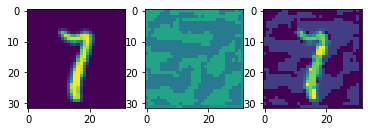

In [74]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(32, 32).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((c_med*EPS).reshape(32, 32).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(32, 32).detach().numpy())
plt.show()

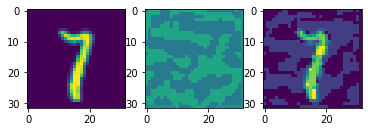

In [75]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(32, 32).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((champ*EPS).reshape(32, 32).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(32, 32).detach().numpy())
plt.show()

## Generation

In [ ]:
sals, success = generate_saliency(0.18,0,images)
c_med, c_mean, champ = combine_saliencies(sals,success)

In [ ]:
EPS = 0.18
SAVE_DIR = "./"
# for i in range(len(train_dataset.targets)):
target_len = len(train_dataset.classes)
counter     = 1
successes   = []
orgTarget   = [] 
falseTarget = []

skip = 0
stop = 3
for data in train_loader:
    if counter < skip:
        counter +=1
        continue
    images_med   = []
    images_mean  = []
    images_champ = []
    tru_labels   = []
    images, labels = data
    print("\r Batch %s" % counter, end="")
    for i in range(images.shape[0]): #
        print(i)
        # the real target
        target_org = labels[i].item()
        # the target that wanted to be resulted in
        target     = int(np.random.choice(list(set(range(target_len)) - set([target_org])),size=1))
        image      = images[i:i+1,:,:,:]
        # generating saliency maps using each sampled network
        temp_sals, success = generate_saliency(EPS,target,image)
        successes.append(success)
        orgTarget.append(target_org)
        falseTarget.append(target)
        # combining maps into three types
        combined_med, combined_mean, champ = combine_saliencies(temp_sals,success)
        # creating image
        images_med.append(otcm(image, EPS, combined_med))
        images_mean.append(otcm(image, EPS, combined_mean))
        images_champ.append(otcm(image, EPS, champ))
        tru_labels.append(target_org)
    tru_labels   = torch.tensor(tru_labels)

    images_med   = (torch.vstack(images_med)*255).type(torch.uint8).detach()
    images_mean  = (torch.vstack(images_mean)*255).type(torch.uint8).detach()
    images_champ = (torch.vstack(images_champ)*255).type(torch.uint8).detach()
    images_med   = {'images': images_med,  'labels': tru_labels}
    images_mean  = {'images': images_mean, 'labels': tru_labels}
    images_champ = {'images': images_champ,'labels': tru_labels}


#     with open(SAVE_DIR + 'train_images_med_%s.pickle'   % counter, 'wb') as handle:
#         pickle.dump(images_med, handle, protocol  = pickle.HIGHEST_PROTOCOL)
#     with open(SAVE_DIR + 'train_images_mean_%s.pickle'  % counter, 'wb') as handle:
#         pickle.dump(images_mean, handle, protocol = pickle.HIGHEST_PROTOCOL)
#     with open(SAVE_DIR + 'train_images_champ_%s.pickle' % counter, 'wb') as handle:
#         pickle.dump(images_champ, handle, protocol= pickle.HIGHEST_PROTOCOL)
    counter += 1
    if counter > stop:
        print("braking")
        break

## Adversarial Training

In [135]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [136]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [137]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.05/") if d.startswith("train_images_med")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [138]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.05//" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [140]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [141]:
img = next(iter(train_loader))

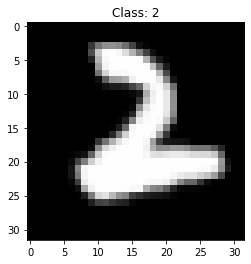

In [142]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [143]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [144]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn-adv-med0.05.pt")

Epoch:0, TrainLoss:8949.661, TrainAcc:0.973, ValLoss:8815.307, ValAcc:0.975, KL:35952.331
Epoch:1, TrainLoss:8331.902, TrainAcc:0.975, ValLoss:8980.602, ValAcc:0.973, KL:35115.529
Epoch:2, TrainLoss:7778.730, TrainAcc:0.978, ValLoss:8261.433, ValAcc:0.977, KL:34635.471
Epoch:3, TrainLoss:7666.301, TrainAcc:0.978, ValLoss:8226.040, ValAcc:0.975, KL:34100.247
Epoch:4, TrainLoss:7431.978, TrainAcc:0.979, ValLoss:8325.451, ValAcc:0.976, KL:33713.422
Epoch:5, TrainLoss:7143.370, TrainAcc:0.981, ValLoss:8008.452, ValAcc:0.976, KL:33158.879
Epoch:6, TrainLoss:6964.101, TrainAcc:0.980, ValLoss:8216.730, ValAcc:0.975, KL:32673.102
Epoch:7, TrainLoss:6826.943, TrainAcc:0.982, ValLoss:8213.214, ValAcc:0.975, KL:32222.349
Epoch:8, TrainLoss:6733.833, TrainAcc:0.982, ValLoss:7880.064, ValAcc:0.977, KL:31912.593
Epoch:9, TrainLoss:6353.305, TrainAcc:0.983, ValLoss:7803.279, ValAcc:0.980, KL:31599.982
Epoch:10, TrainLoss:6362.029, TrainAcc:0.983, ValLoss:7619.875, ValAcc:0.979, KL:31359.545
Epoch:11,

## Adversarial Training Champ

In [145]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [146]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [147]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.05/") if d.startswith("train_images_champ")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [148]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.05/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [150]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [151]:
img = next(iter(train_loader))

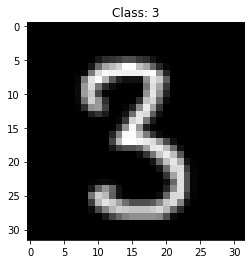

In [152]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [153]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn-adv-champ0.05.pt")

Epoch:0, TrainLoss:5748.950, TrainAcc:0.985, ValLoss:7297.304, ValAcc:0.978, KL:28318.823
Epoch:1, TrainLoss:5604.724, TrainAcc:0.986, ValLoss:6953.296, ValAcc:0.982, KL:28425.381
Epoch:2, TrainLoss:5523.580, TrainAcc:0.986, ValLoss:7027.331, ValAcc:0.980, KL:28654.955
Epoch:3, TrainLoss:5468.697, TrainAcc:0.987, ValLoss:6825.225, ValAcc:0.982, KL:28711.553
Epoch:4, TrainLoss:5469.264, TrainAcc:0.987, ValLoss:7226.810, ValAcc:0.982, KL:28803.916
Epoch:5, TrainLoss:5562.123, TrainAcc:0.986, ValLoss:6808.629, ValAcc:0.981, KL:29043.431
Epoch:6, TrainLoss:5333.678, TrainAcc:0.988, ValLoss:6939.312, ValAcc:0.982, KL:29171.288
Epoch:7, TrainLoss:5457.837, TrainAcc:0.987, ValLoss:7125.187, ValAcc:0.981, KL:29041.696
Epoch:8, TrainLoss:5298.181, TrainAcc:0.988, ValLoss:7094.158, ValAcc:0.981, KL:28945.895
Epoch:9, TrainLoss:5208.028, TrainAcc:0.988, ValLoss:7566.662, ValAcc:0.981, KL:28774.984
Epoch:10, TrainLoss:5101.284, TrainAcc:0.988, ValLoss:6604.559, ValAcc:0.982, KL:28617.199
Epoch:11,

## Adversarial Training (eps= 0.18)

In [175]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [176]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [177]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.18/") if d.startswith("train_images_med")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [178]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.18/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [179]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [180]:
img = next(iter(train_loader))

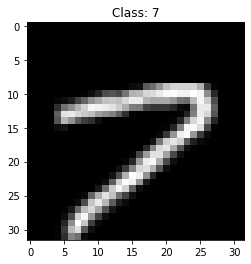

In [181]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [182]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [184]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-med0.18.pt")

Epoch:0, TrainLoss:6328.549, TrainAcc:0.982, ValLoss:6058.759, ValAcc:0.983, KL:28087.034
Epoch:1, TrainLoss:6107.050, TrainAcc:0.983, ValLoss:6719.151, ValAcc:0.980, KL:28581.676
Epoch:2, TrainLoss:5874.656, TrainAcc:0.985, ValLoss:6654.492, ValAcc:0.980, KL:28847.441
Epoch:3, TrainLoss:5688.220, TrainAcc:0.986, ValLoss:6139.992, ValAcc:0.982, KL:29071.327
Epoch:4, TrainLoss:5593.068, TrainAcc:0.986, ValLoss:6237.446, ValAcc:0.982, KL:29128.288
Epoch:5, TrainLoss:5347.973, TrainAcc:0.988, ValLoss:6199.795, ValAcc:0.984, KL:28983.227
Epoch:6, TrainLoss:5237.087, TrainAcc:0.988, ValLoss:6407.690, ValAcc:0.983, KL:28864.655
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch:7, TrainLoss:5344.323, TrainAcc:0.987, ValLoss:6852.710, ValAcc:0.982, KL:28852.665
Epoch:8, TrainLoss:4919.120, TrainAcc:0.989, ValLoss:5830.979, ValAcc:0.985, KL:28871.863
Epoch:9, TrainLoss:4996.001, TrainAcc:0.989, ValLoss:5803.739, ValAcc:0.985, KL:28731.249
Epoch:10, TrainLoss:4837.497, TrainAcc

## Adversarial Training (eps= 0.18, champ)

In [185]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [186]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [187]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.18/") if d.startswith("train_images_champ")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [188]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.18/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [189]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [190]:
img = next(iter(train_loader))

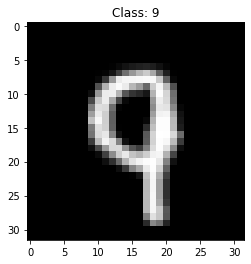

In [191]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [192]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [193]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-champ0.18.pt")

Epoch:0, TrainLoss:5160.353, TrainAcc:0.987, ValLoss:6292.461, ValAcc:0.982, KL:27207.201
Epoch:1, TrainLoss:5070.413, TrainAcc:0.988, ValLoss:6765.373, ValAcc:0.981, KL:27369.277
Epoch:2, TrainLoss:5380.323, TrainAcc:0.987, ValLoss:6474.751, ValAcc:0.984, KL:27846.429
Epoch:3, TrainLoss:5080.209, TrainAcc:0.988, ValLoss:6512.425, ValAcc:0.983, KL:28110.186
Epoch:4, TrainLoss:5079.756, TrainAcc:0.988, ValLoss:6503.413, ValAcc:0.982, KL:28056.009
Epoch:5, TrainLoss:5125.309, TrainAcc:0.988, ValLoss:6360.784, ValAcc:0.983, KL:28119.157
Epoch:6, TrainLoss:4976.825, TrainAcc:0.989, ValLoss:6396.181, ValAcc:0.983, KL:28137.779
Epoch:7, TrainLoss:4958.926, TrainAcc:0.989, ValLoss:5970.411, ValAcc:0.984, KL:28019.700
Epoch:8, TrainLoss:4828.485, TrainAcc:0.989, ValLoss:7112.312, ValAcc:0.982, KL:27940.775
Epoch:9, TrainLoss:4892.673, TrainAcc:0.989, ValLoss:6161.597, ValAcc:0.985, KL:27869.739
Epoch:10, TrainLoss:4908.512, TrainAcc:0.989, ValLoss:6152.966, ValAcc:0.985, KL:27877.910
Epoch:11,